# Primate-specific ZNF808 is essential for pancreatic development in humans

## Notebook to perform transcriptomic analysis to generate figure panels.

This notebook takes clusters of the H3K9me3 and HEK27ac epigenetic data over pancreatic differentiation time course and then analyses transcriptomic data collected at same stages in light of clusters.

Note repository contains source data for all gene expression and quantifications of ChIP-seq at particular loci. Repository does not contain alignment files, but code is supplied to regenerate quantifications if suitable alignment files are present.

For epigenomic analysis, see folder `Imbeault_lab` within this repository

In [1]:
include(joinpath("..", "src", "project.jl"));

C:\Users\ndlo201\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)

(process:51800): GLib-GIO-WARNING **: 10:58:02.658: Unexpectedly, UWP app `Microsoft.OutlookForWindows_1.2023.920.900_x64__8wekyb3d8bbwe' (AUMId `Microsoft.OutlookForWindows_8wekyb3d8bbwe!Microsoft.OutlookforWindows') supports 1 extensions but has no verbs


In [2]:
genetss, lrois, mer11, genemodels, laser_dorsal_hep, human_embryo_rnaseq, meta, counts, ncounts, enrichrgenes, peakmeta, FM, stagelabels, gtex, convdata = loadall();

In [3]:
@time deresults =  enrichments(deseq_batch_local(meta, counts, genetss), laser_dorsal_hep, enrichrgenes);
saveenrichr(deresults.enfisher, stagelabels);

Running DESeq sharing information between local stages, experiment batch effect...


DESeq by Stage: 100%|███████████████████████████████████| Time: 0:00:52
Enrichr API   : 100%|███████████████████████████████████| Time: 0:01:09
Recalc Enrichr: 100%|████████████████████████████████████| Time: 0:02:18


276.718998 seconds (2.05 G allocations: 92.887 GiB, 4.02% gc time, 6.95% compilation time)


### Load epigenetics clusters and perform proximity enrichments to RNA-seq

In [4]:
epiclusters = clusterpeaks(deresults, mer11);

Proximity Enrichments: 100%|████████████████████████████| Time: 0:00:02


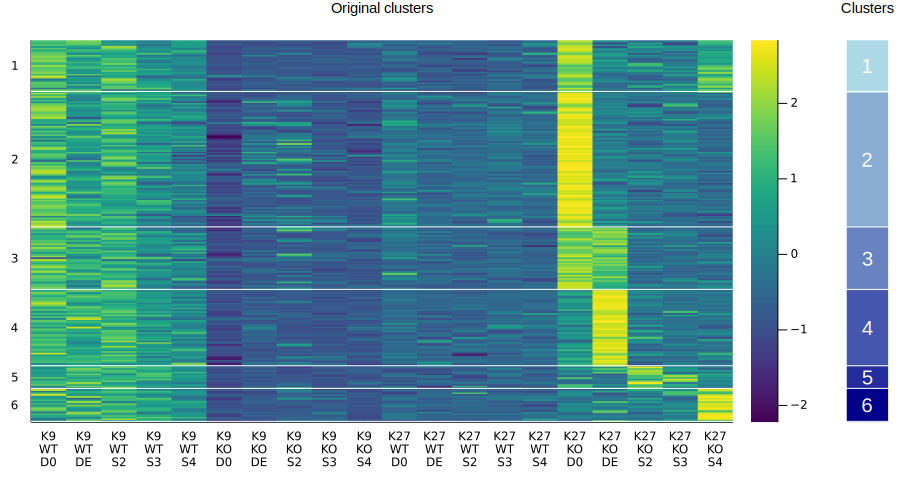

In [5]:
mKMK = cluster_result_from_assignment(epiclusters.mcl.MI_CL6)
ph = heatmap(epiclusters.ZMS[mKMK.SI,  :])
clusterlines!(mKMK)
plot!(yflip=true)
@with @subset(peakmeta, :GenoType .!= "iPSC", :Stage .∈ Ref(deresults.stages)) plot!(xticks=(1:length(:Chip), string.(:Chip, "\n", :GenoType, "\n", :Stage)), size=(1000, 500), bottom_margin=10mm, title="Original clusters")
pc = heatmap(epiclusters.mcl.MI_CL6[mKMK.SI, :], yflip=true, colorbar=false, c=:blues, size=(100, 300), xticks=false, yticks=false, framestyle=:none, title="Clusters")
hline!(cumsum(mKMK.KM.counts), lab="", c=:white)
annotate!([(1, v, text(i, font("helvetica", :white))) for (i, v) in enumerate(cumsum(mKMK.KM.counts) .- mKMK.KM.counts/2)])
plot(ph, pc, layout=grid(1, 2, widths=[0.95, 0.05]), size=(900, 500), titlefont=font(10, "helvetica"), top_margin=5mm)

### Annotate MER11 distances

In [6]:
@with epiclusters.mcl annotatemerdist!(deresults.deg, Interval.(:chrom, :start, :stop), "dMER11");
deresults.deg[!, :pMER11] = coalesce.(deresults.deg.dMER11, 1e+8) .< 1e+6;

# Figure 4

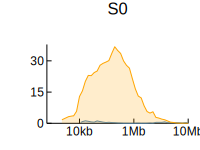

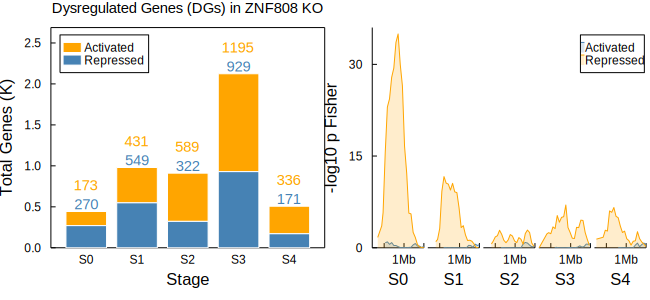

In [7]:
fig4A = plottotalde(deresults.deg, stagelabels)
plot!(leg=:topleft)
fig4B_inset = proxplot(@subset(epiclusters.proxmcl, :Stage .== "D0"), ["MER_ALL"], labs=["Activated" "Repressed"], dx=1)
plot!(size=(200, 150), leg=false, yticks=0:15:30, ylabel="", title="S0", xticks=([4, 6, 8], ["10kb", "1Mb", "10Mb"]))
savedisplay("fig4b_inset")

pp = proxplot(epiclusters.proxmcl, ["MER_ALL"], labs=["Activated" "Repressed"], dx=2)
plot!(framestyle=:default)
plot!(pp.subplots[1], yticks=0:15:30)
for p in pp.subplots[2:end]
    plot!(p, yaxis=false)
end
[plot!(p, title="", xlabel=stagelabels[s]) for (p, s) in zip(pp.subplots, deresults.stages)]
fig4B = plot!(pp, xticks=([4, 6, 8], ["", "1Mb", ""]), right_margin=-1mm, left_margin=-2mm, size=(300, 400))
plot(fig4A, fig4B, layout=(1, 2), size=(650, 300), fontfamily="helvetica", bottom_margin=5mm, titlefont=font(10, "helvetica"))
savedisplay("fig_4ab")

#### Human readable summary of proximity enrichments:

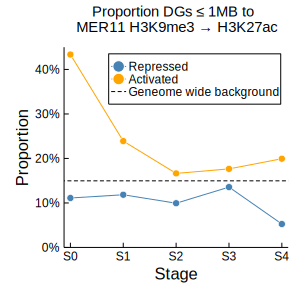

In [8]:
epiproxproption(deresults)
yticks!(0:.1:.4, string.(0:10:40, "%"))
plot!(size=(300, 300), titlefont=font(10, "helvetica"), ylims=(0, .45))
savedisplay("fig_4_prox_enrich_simple")

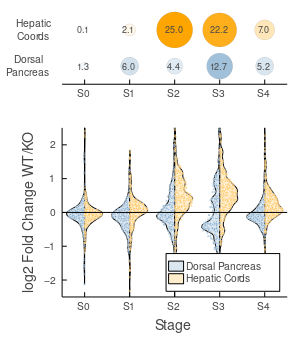

In [9]:
fig4C = panc_hep_enrichment_plot(deresults, laser_dorsal_hep)
savedisplay("fig_4c_v2")

### Annotate GTEx liver exclusive and hepatic cord genes:

In [10]:
deresults.deg[!, :GTExLiver]   = deresults.deg.GeneName .∈ Ref(Set(gtex.liver_exclusive.GeneName));
deresults.deg[!, :HepaticCord] = deresults.deg.GeneName .∈ Ref(Set(@subset(laser_dorsal_hep, :LSD .== -1).GeneName));

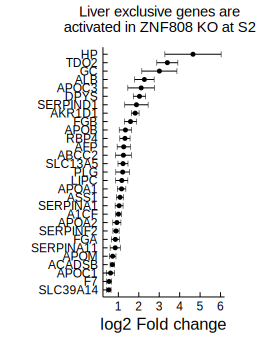

In [11]:
df = sort(@subset(deresults.deg, :dsig .== 1, :GTExLiver .== 1, :HepaticCord .== 1, :Stage .== "S2"), :log2FoldChange) 
fig4D = @with df scatter( :log2FoldChange, 1:length(:Gene), leg=false, xerror=:lfcSE, yticks=(1:length(:GeneName), :GeneName), marker=(3))
plot!(grid=false, size=(260, 350), left_margin=10mm, xlabel="log2 Fold change", fontfamily="helvetica", title="Liver exclusive genes are\nactivated in ZNF808 KO at S2", titlefont=font("helvetica", 10), right_margin=7mm)
savedisplay("fig_4d_v2")

# Supplemental Figures


### Supplementary Figure 1 
- GTEx of ZNF808
- Expression of MER11 binding ZNFs in human embryo RNA-seq
- Gene sequence conservation between primate and non-primate mammals

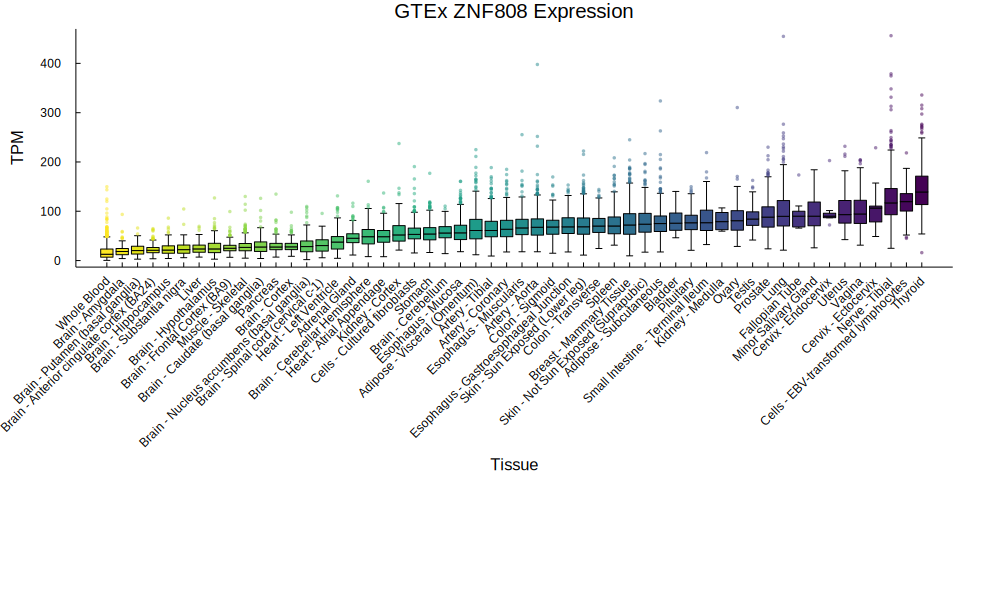

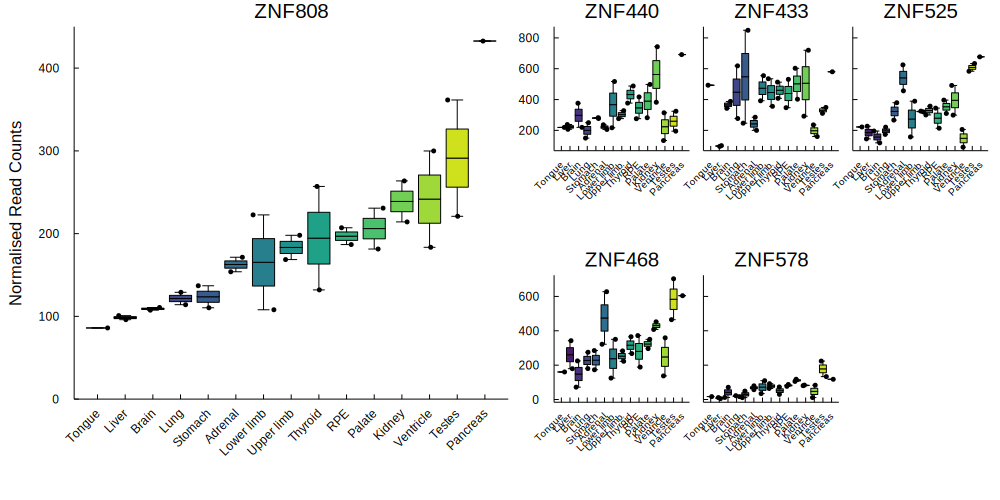

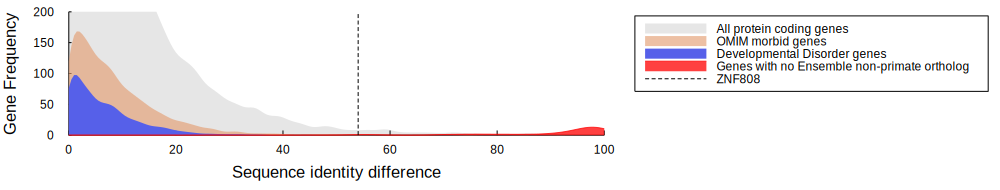

In [12]:
znf808_gtex = loadgtexgct();
gtexboxplot(znf808_gtex.genetpm, rev=true)
savedisplay("supfig_1a")

plot_human_embryo_rnaseq_boxplot(human_embryo_rnaseq)
savedisplay("supfig_1b")

plot_conservation_distributions(convdata)
savedisplay("supfig_1c")

### Supplementary Figure 6 
Expression of KRAB ZNFs and other TFs binding MER11 elements

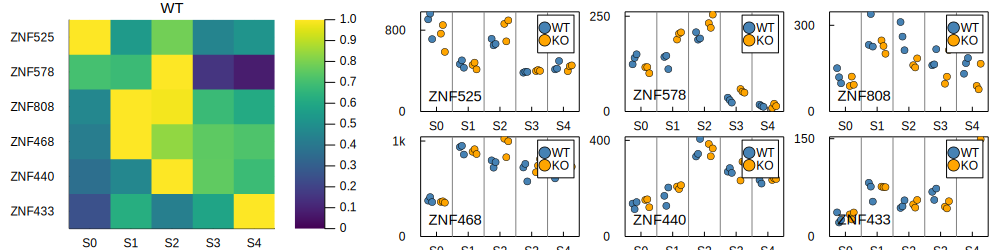

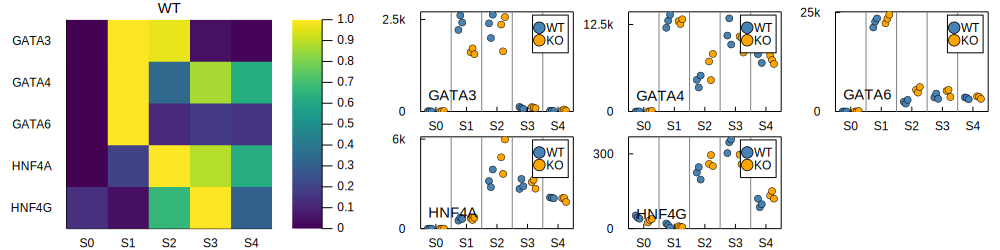

In [13]:
sup_fig7ab = geneheatmap_scatter(r"ZNF(808|525|440|468|433|578)$", deresults, size=(1000, 250), fontfamily="helvetica", titlefont=font(10, "helvetica"))
savedisplay("supfig_6ab")
sup_fig7cd = geneheatmap_scatter(r"GATA(1|3|4|6)$|HNF4A|HNF4G$",  deresults, k=5, size=(1000, 250), fontfamily="helvetica", titlefont=font(10, "helvetica"))
savedisplay("supfig_6cd")

### Supplementary Figure 8 
RNA-seq proximity to MER11 enrichments (TMTC1 example inclusive) and gene set enrichments

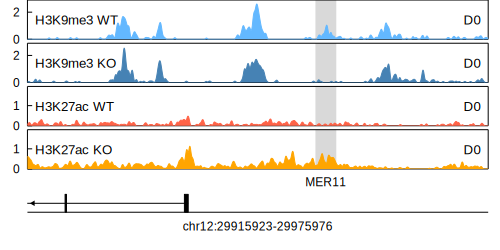

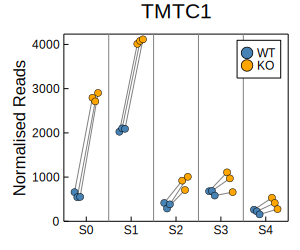

extrema(O) = (1.11628741577824, 75.0)


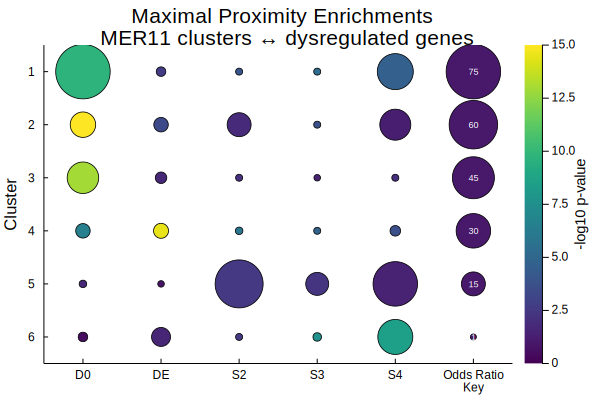

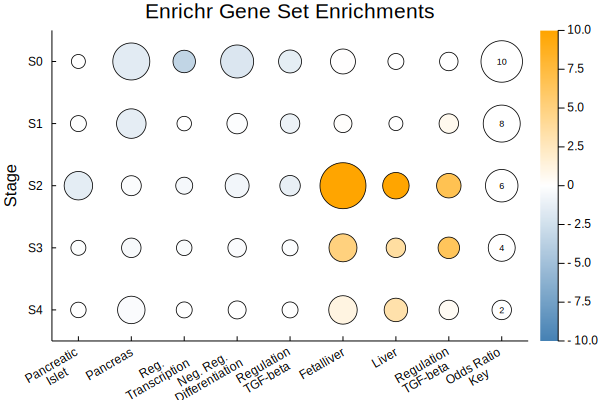

In [14]:
supfig_9a = plot_gene_snapshot(lrois["TMTC1"]..., @subset(peakmeta,  :Stage .== "D0"), FM, mer11, genemodels, label="epi_h1", merex=1000, dx=50, transcripts=["ENST00000539277.6_8"], plottype=:stack, yld=Dict("K9" => 2.9, "K27" => 1.95))
plot!(size=(500, 250), fontfamily="helvetica") 
savedisplay("supfig_8a")

supfig_9b = plotgenesimple(r"\|TMTC1$", deresults, stagelabels, plotpair=true)
plot!(size=(300, 250), fontfamily="helvetica", leg=:topright)
savedisplay("supfig_8b")

supfig_9c = epi_bubble(epiclusters, deresults, msm=3.5, omax=75)
plot!(colorbar_title="-log10 p-value")
savedisplay("supfig_8c")

supfig_9d = enrichrplot(deresults.enfisher, ["Fetalliver", "Liver", "TGF-beta regulation of extracellular matrix"],
    ["PancreaticIslet", "Pancreas", "regulation of transcription from RNA polymerase II promoter (GO:0006357)", "negative regulation of cell differentiation (GO:0045596)", "TGF-beta regulation of extracellular matrix"], 10)
savedisplay("supfig_8d")

### Supplementary Figure 9 
GTEx liver exclusive genes

Calculate GTEx enrichments:

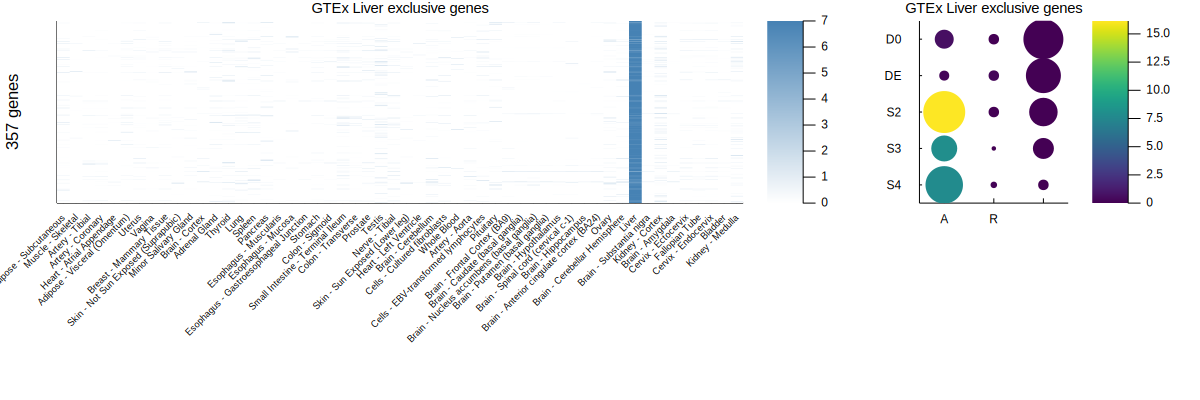

In [15]:
gtex_enrich = gtex_enrichments(gtex, deresults);
### heatmap of liver exclusive genes
gtex_median_liver = @subset(gtex.median, :GeneId .∈ Ref(Set(gtex.liver_exclusive.GeneId)));
ML = Matrix(gtex_median_liver[!, 3:end]);
Z = (ML .- mean(ML, dims=2))./std(ML, dims=2)
p_gtex_liver = heatmap(Z, size=(1000, 400), c=cgrad([:white, :steelblue]), clims=(0, 7))
plot!(yticks=false, ylabel=string(size(Z, 1), " genes"))
plot!(xticks=(1:size(Z, 2), names(gtex_median_liver)[3:end]), xrotation=45, bottom_margin=35mm, xtickfont=font("helvetica", 6), left_margin=10mm, )


### enrichments
pvdf = unstack(gtex_enrich, :Stage, :Direction, :pvalue)
ordf = unstack(gtex_enrich, :Stage, :Direction, :OR)
@assert names(pvdf) == names(ordf)
@assert pvdf.Stage == ordf.Stage
P = Matrix(pvdf[!, 2:end])
OR = Matrix(ordf[!, 2:end])
P = [P ones(size(P, 1))]
OR = [OR reverse(range(1, 7, length=5))]
p_gtex_bubble = bubbleplot(-log10.(P), OR, msm=10, mso=-4, xticks=(1:size(P, 2), names(pvdf)[2:end]) ,leg=false, yticks=(1:size(P, 1), pvdf.Stage), size=(200, 300), colorbar=true)

plot(p_gtex_liver, p_gtex_bubble, layout=grid(1, 2, widths=[0.75, .25]), size=(1200, 400))
plot!(fontfamily="helvetica", title="GTEx Liver exclusive genes",  titlefont=font(10, "helvetica"))
savedisplay("supfig_9ab")

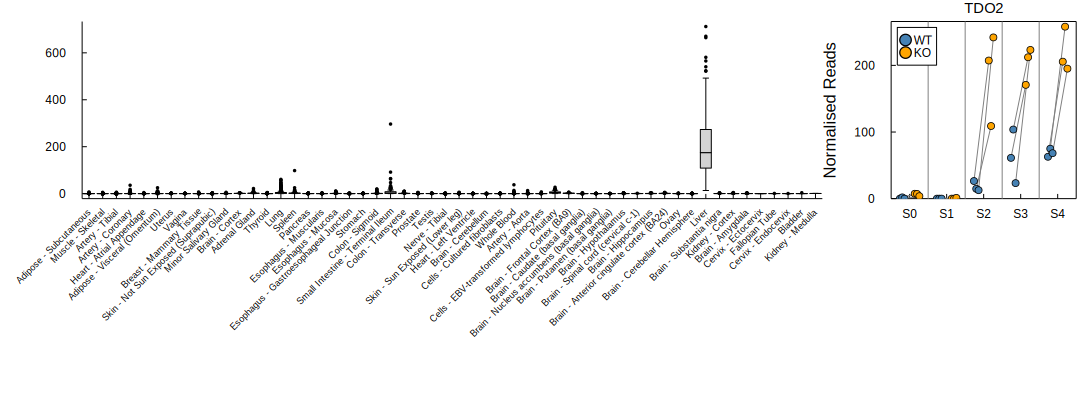

In [16]:
p_tdo2_box = @with @subset(gtex.tdo2, :Gene .== "TDO2") boxplot(:GroupIndex, :TPM, grid=false, c=^(:lightgrey), marker=(stroke(0), 2, ^(:black)))
gtex_ticks = sort(unique(@subset(gtex.tdo2, :Gene .== "TDO2")[!, [:GroupIndex, :Tissue]]), :GroupIndex)
plot!(xticks=(gtex_ticks.GroupIndex, gtex_ticks.Tissue), xrotation=45, bottom_margin=35mm, xtickfont=font("helvetica", 6), left_margin=10mm, )
plot!(size=(1000, 400), leg=false, xlims=(0.5, 54.5))

p_tdo2 = plotgenesimple(r"TDO2$", deresults, stagelabels, plotpair=true)
plot!(size=(400, 200), leg=:topleft, yticks=0:100:200)

plot(p_tdo2_box, p_tdo2, layout=grid(1, 2, widths=[0.8, .2]), size=(1088, 400))
plot!(fontfamily="helvetica", titlefont=font(10, "helvetica"))
savedisplay("supfig_9cd")

In [17]:
tdo2 = "chr4", 156792868:156845136 ## hg19 coords
plot_gene_snapshot(tdo2..., peakmeta, FM, mer11, genemodels, transcripts=["ENST00000536354.3_2"], label="tdo2", merex=1000, dx=20, plottype=:stack, yld=Dict("K9" => 1.5, "K27" => 0.9))
plot!(size=(650, 600), fontfamily="helvetica")
savedisplay("supfig_9e")

### Supplementary Figure 10 
GTEx liver exclusive genes

Calculate GTEx enrichments:

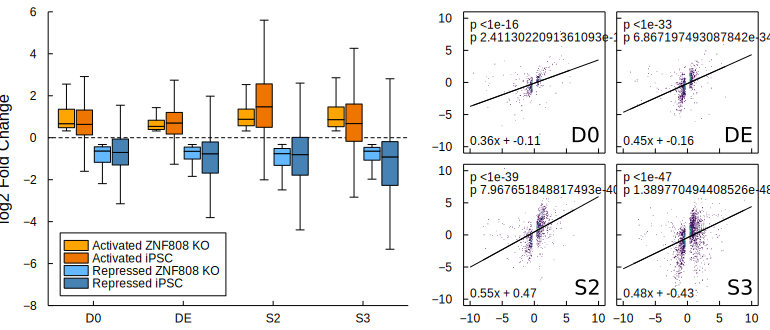

In [18]:
meta_ips, counts_ips = loadrnaseq(joinpath(getprojectdir(), "data", "rnaseq_meta_ips.tsv"), joinpath(getprojectdir(), "data", "rnaseq_counts_ips.tsv.gz"));
meta_ips.GenoTypeIPS .= "IPS";
@assert counts.Gene == counts_ips.Gene
counts_all = [counts counts_ips[!, Not(:Gene)]]
meta_all = [meta ; meta_ips];
setupdeseq(meta_all, counts_all)
ncounts_all = normcounts();

ips_comparison(deresults, meta_all, ncounts_all)
savedisplay("supfig_10b")

# Save differentially expressed gene table

In [19]:
CSV.write(joinpath(getprojectdir(), "results", "znf808_deresults.tsv.gz"), deresults.deg, delim='\t', compress=true);

## Rebuttal Figures

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Writing C:\home\projects\znf808\paper\figures\stage4_only\mac\upload\ZNF808Genomics\figures\rebuttal_prox_mer11_liver.png


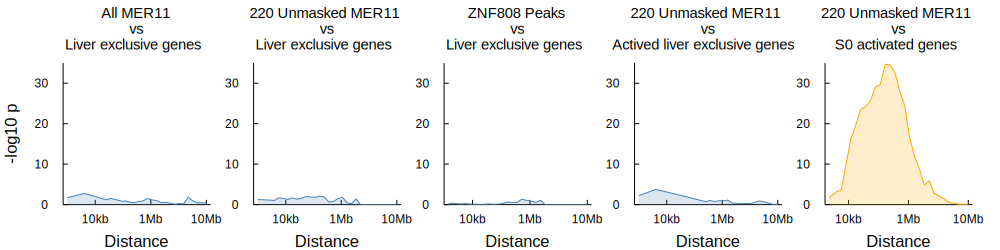

Proximity Enrichments: 100%|████████████████████████████| Time: 0:00:00


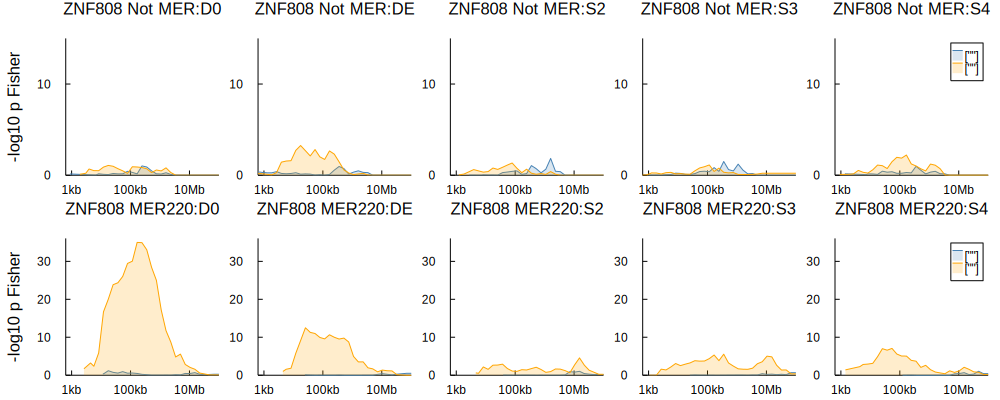

In [20]:
znf808 = CSV.read(joinpath(getprojectdir(), "data", "GSM2466672_ZNF808_peaks_processed_score_signal_exo.bed.gz"), DataFrame, header=[:chrom, :start, :stop, :name, :score, :strand])
sort!(znf808, [:chrom, :start])
znf808_ivs = @with znf808 Interval.(:chrom, :start, :stop);
mer220_ivs = @with epiclusters.mcl Interval.(:chrom, :start, :stop);
mer11_ivs = @with mer11 Interval.(:chrom, :start, :stop);

gtex_liver_tss = deresults.deg[!, [:GeneName, :chrom, :TSS, :strand, :GTExLiver]] |> unique
stage0_control = sort!(@subset(deresults.deg, :Stage .== "D0"), [:chrom, :TSS])
gtex_liver_tss = combine(groupby(deresults.deg, [:GeneName, :chrom, :TSS, :strand, :GTExLiver]), :sig => maximum => :sig, :dsig => maximum => :dsig)
sort!(gtex_liver_tss, [:chrom, :TSS])
gtex_liver_iv = @with gtex_liver_tss Interval.(:chrom, :TSS, :TSS, first.(:strand));
stage0_control_iv = @with stage0_control Interval.(:chrom, :TSS, :TSS, first.(:strand));
xp = range(0, 8, length=50)

mer220_control = proxenrich(xp, stage0_control_iv, mer220_ivs, stage0_control.dsig .== 1)
merall_liver_prox = proxenrich(xp, gtex_liver_iv, mer220_ivs, gtex_liver_tss.GTExLiver)
merall_liver_prox_cluster = @showprogress [proxenrich(xp, gtex_liver_iv, mer220_ivs[epiclusters.mcl.MI_CL6 .== k], gtex_liver_tss.GTExLiver) for k = 1:6]

mer_liver_prox    = proxenrich(xp, gtex_liver_iv, mer11_ivs, gtex_liver_tss.GTExLiver)
znf808_liver_prox = proxenrich(xp, gtex_liver_iv, znf808_ivs, gtex_liver_tss.GTExLiver);
mer_liver_prox_de = proxenrich(xp, gtex_liver_iv, mer220_ivs, gtex_liver_tss.GTExLiver .& (gtex_liver_tss.dsig .== 1));

p0 = plot(mer220_control.xg, -log10.(mer220_control.pvalue), c=:orange, fill=0, fillalpha=0.2, ylims=(0, 15), title="220 Unmasked MER11\nvs\nS0 activated genes")
p1 = plot(merall_liver_prox.xg, -log10.(merall_liver_prox.pvalue), c=:steelblue, fill=0, fillalpha=0.2, ylims=(0, 15), title="All MER11\nvs\nLiver exclusive genes")
p2 = plot(mer_liver_prox.xg, -log10.(mer_liver_prox.pvalue), c=:steelblue, fill=0, fillalpha=0.2, ylims=(0, 15), title="220 Unmasked MER11\nvs\nLiver exclusive genes")
p3 = plot(znf808_liver_prox.xg, -log10.(znf808_liver_prox.pvalue), c=:steelblue, fill=0, fillalpha=0.2, lab="", ylims=(0, 15), title="ZNF808 Peaks\nvs\nLiver exclusive genes")
p4 = plot(mer_liver_prox_de.xg, -log10.(mer_liver_prox_de.pvalue), c=:steelblue, fill=0, fillalpha=0.2, ylims=(0, 15), title="220 Unmasked MER11\nvs\nActived liver exclusive genes")

phs = [p1, p2, p3, p4, p0]
for p in phs[2:end]
   plot!(p, left_margin=-5mm) 
end

plot!(phs[1], ylabel="-log10 p")
plot(phs..., layout=(1, 5), xticks=([4, 6, 8], ["10kb", "1Mb", "10Mb"]), yticks=0:10:30, grid=false, size=(1000, 250), titlefont=font("helvtica", 10), leg=false, xlabel="Distance", margin=5mm, ylims=(0, 35), top_margin=10mm, fontfamily="helvetica")
savedisplay("rebuttal_prox_mer11_liver", [".png", ".svg"], getprojectdir(), true)


markintersection!(znf808, epiclusters.mcl, :MER220)
znf808_not_mer = @with @subset(znf808, .!:MER220) Interval.(:chrom, :start, :stop)
znf808_mer = @with @subset(znf808, :MER220) Interval.(:chrom, :start, :stop)
znf808_ivs_mer = Dict("ZNF808 Not MER" => znf808_not_mer, "ZNF808 MER220" => znf808_mer)
prox_znf808_not_mer = proxde(deresults.deg, znf808_ivs_mer)
pn = proxplot(prox_znf808_not_mer, "ZNF808 Not MER")

pm = proxplot(prox_znf808_not_mer, "ZNF808 MER220")

plot(pn, pm, layout=(2, 1), size=(1000, 400), yticks=0:10:30)
savedisplay("rebbutal_znf808_not_mer")